## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from implementations.mcmc_l1 import sample

In [2]:
RANDOM_SEED = 2022
rng = np.random.default_rng(RANDOM_SEED)

In [55]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Data loading

In [3]:
f = open("./data/spambase.columns", "r")
headers = [line.split(":")[0] for line in f]+["class"]

df = pd.read_csv("./data/spambase.data", header=None) 
df.columns = headers
df.insert(0, "intercept", 1)
df["class"] = df["class"].replace(0,-1)

df.sample(5)

,intercept,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
4053,1,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.0,0.000,1.666,5,25,-1
702,1,0.0,0.0,0.71,0.0,0.71,0.0,0.0,0.0,0.0,...,0.0,0.00,0.256,0.128,0.0,0.000,1.779,11,105,1
4201,1,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.0,0.000,2.843,47,91,-1
3395,1,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.13,0.065,0.065,0.0,1.043,2.983,40,179,-1
4513,1,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.000,0.000,0.0,0.000,3.125,15,50,-1


In [4]:
# Compute X by multiplying each row by the class
X = np.array(df.drop('class', axis=1)) * np.array(df["class"]).reshape(-1,1)

In [5]:
# Number of samples and of dimensions
n, k = X.shape
n, k

(4601, 58)

In [6]:
# Compute variance matrix
sigma = df.drop('class', axis=1).std(axis=0)
sigma[0] = 1
sigma.shape

(58,)

## Study

### Sampling

In [32]:
n_chains = 2
T = 100
n_start = 20 # burn in

In [34]:
nu = 1
betas1 = np.zeros((n_chains,T,k))
for i in range(n_chains):
    betas1[i] = sample(X, sigma, rng, nu, T)

nu = 1e-3
betas2 = np.zeros((n_chains,T,k))
for i in range(n_chains):
    betas2[i] = sample(X, sigma, rng, nu, T)

###  Sparsity of the coefficients

In [77]:
betas1_mean_chain = betas1.mean(axis=0)/n_chains
std_betas1 = betas1_mean_chain[n_start:].mean(axis=0)*sigma

betas2_mean_chain = betas2.mean(axis=0)/n_chains
std_betas2 = betas2_mean_chain[n_start:].mean(axis=0)*sigma

In [78]:
lower_bound1 = np.quantile(betas1_mean_chain, 0.025, axis = 0)
lower_bound2 = np.quantile(betas2_mean_chain, 0.025, axis = 0)

upper_bound1 = np.quantile(betas1_mean_chain, 1-0.025, axis = 0)
upper_bound2 = np.quantile(betas2_mean_chain, 1-0.025, axis = 0)

err1 = upper_bound1-lower_bound1
err2 = upper_bound2-lower_bound2

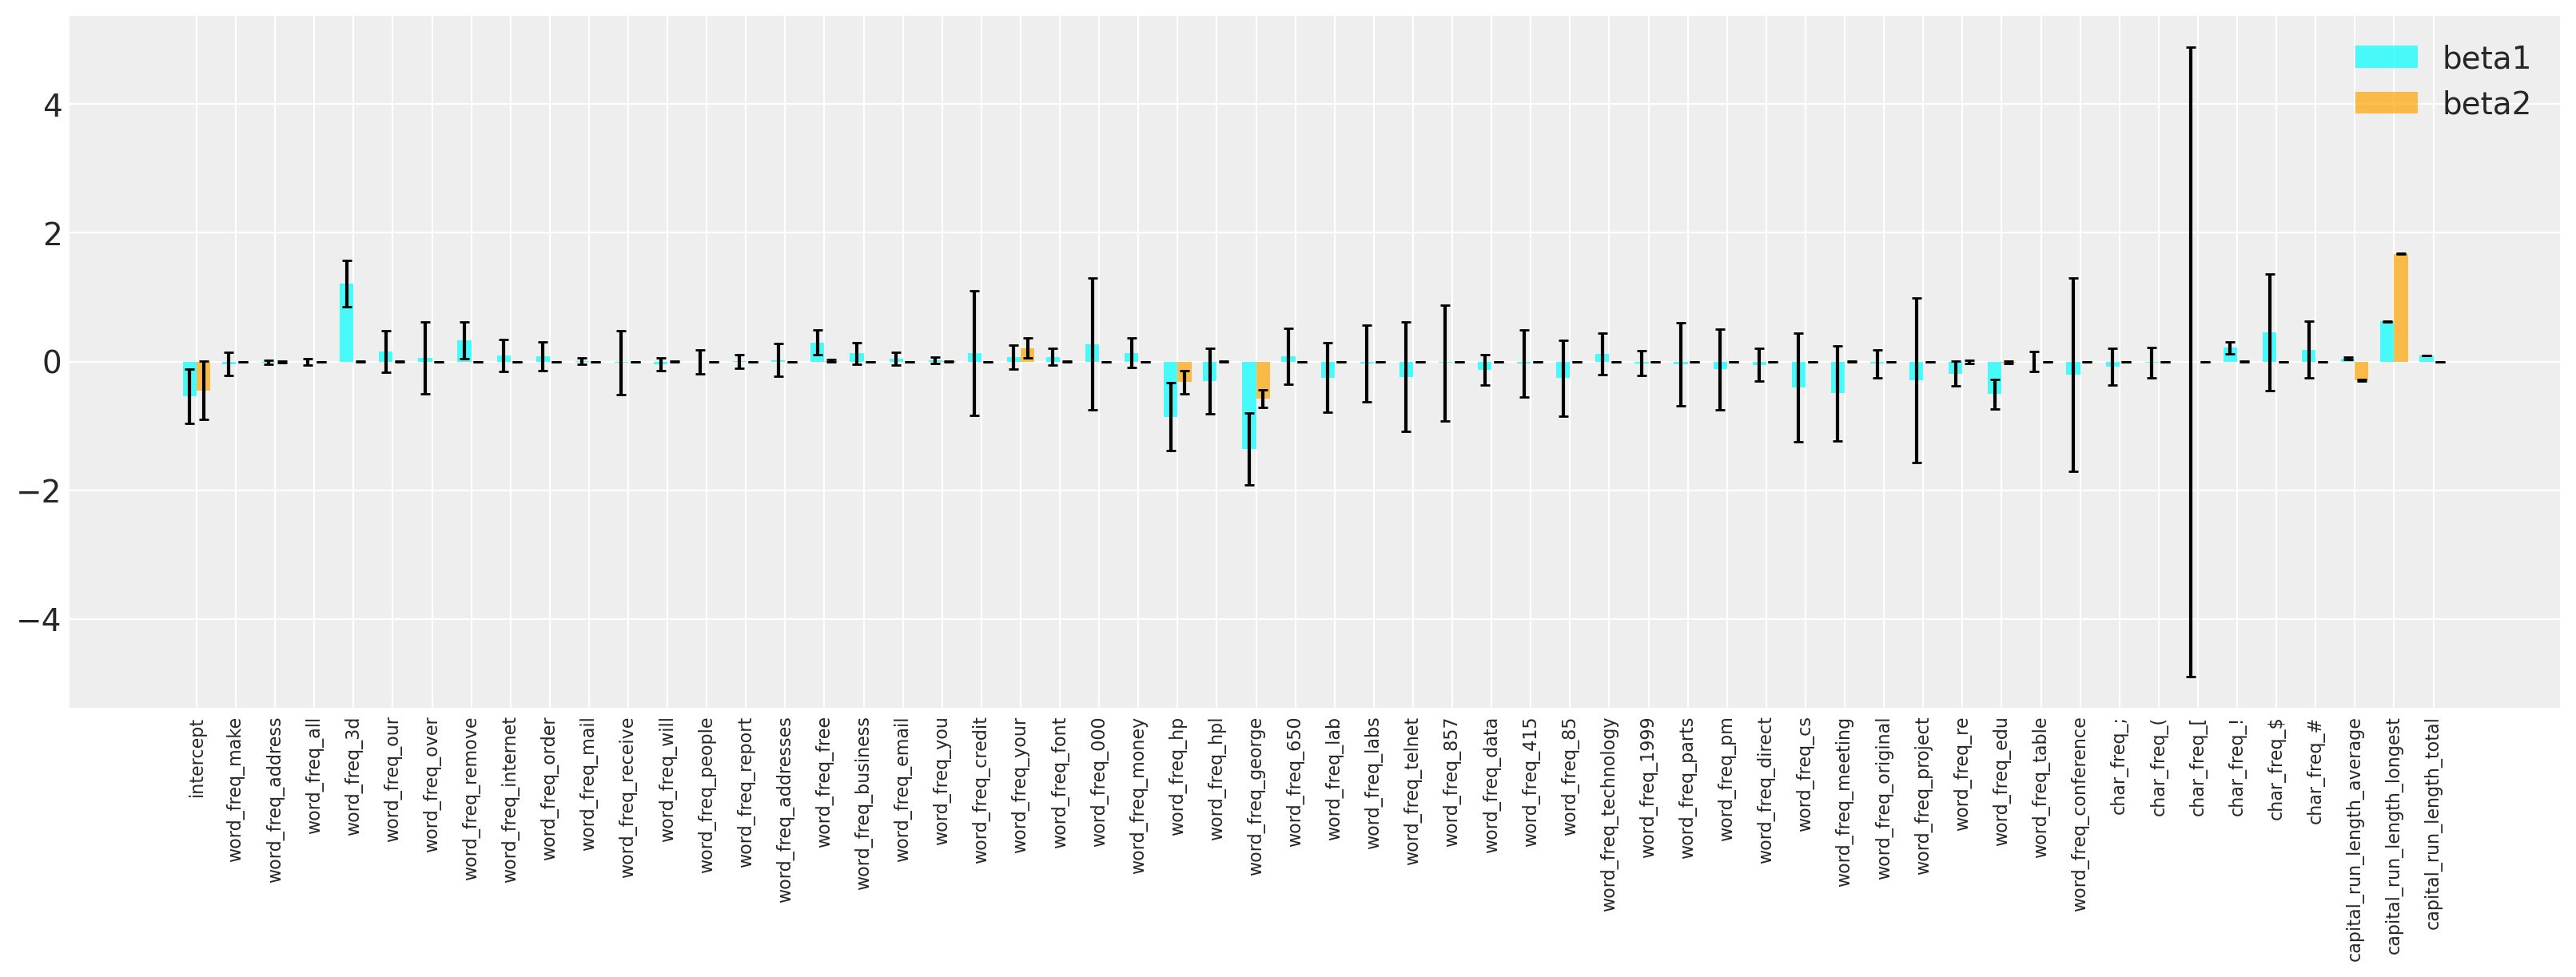

In [79]:
x = np.arange(k)
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
bar1 = ax.bar(x - width / 2, std_betas1, width, label='beta1', alpha=.7, yerr=err1, capsize=2, color="cyan")
bar2 = ax.bar(x + width / 2, std_betas2, width, label='beta2', alpha=.7, yerr=err2, capsize=2, color="orange")

ax.set_xticks(x)
ticks = df.columns[:-1]
ax.set_xticklabels(ticks, fontsize=8)

plt.xticks(rotation=90)
# plt.yscale("log")
plt.legend()
plt.show()

### Convergence of the chains

In [82]:
n_coeffs = 2
coeffs = np.random.randint(k, size = n_coeffs)
colors = ["blue", "red", "green"]

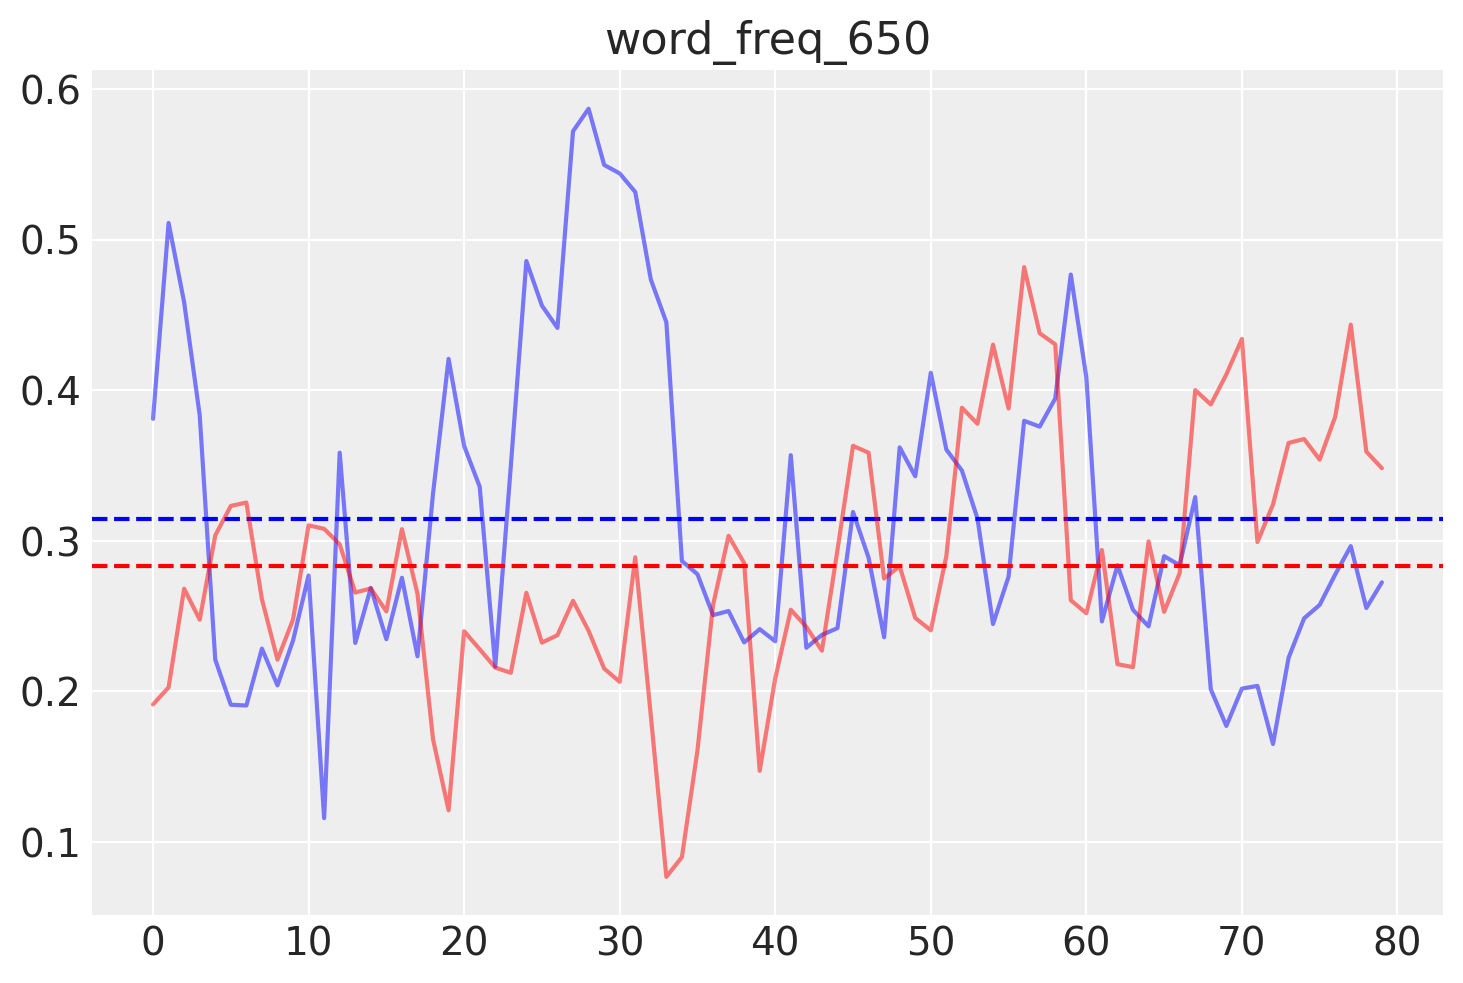

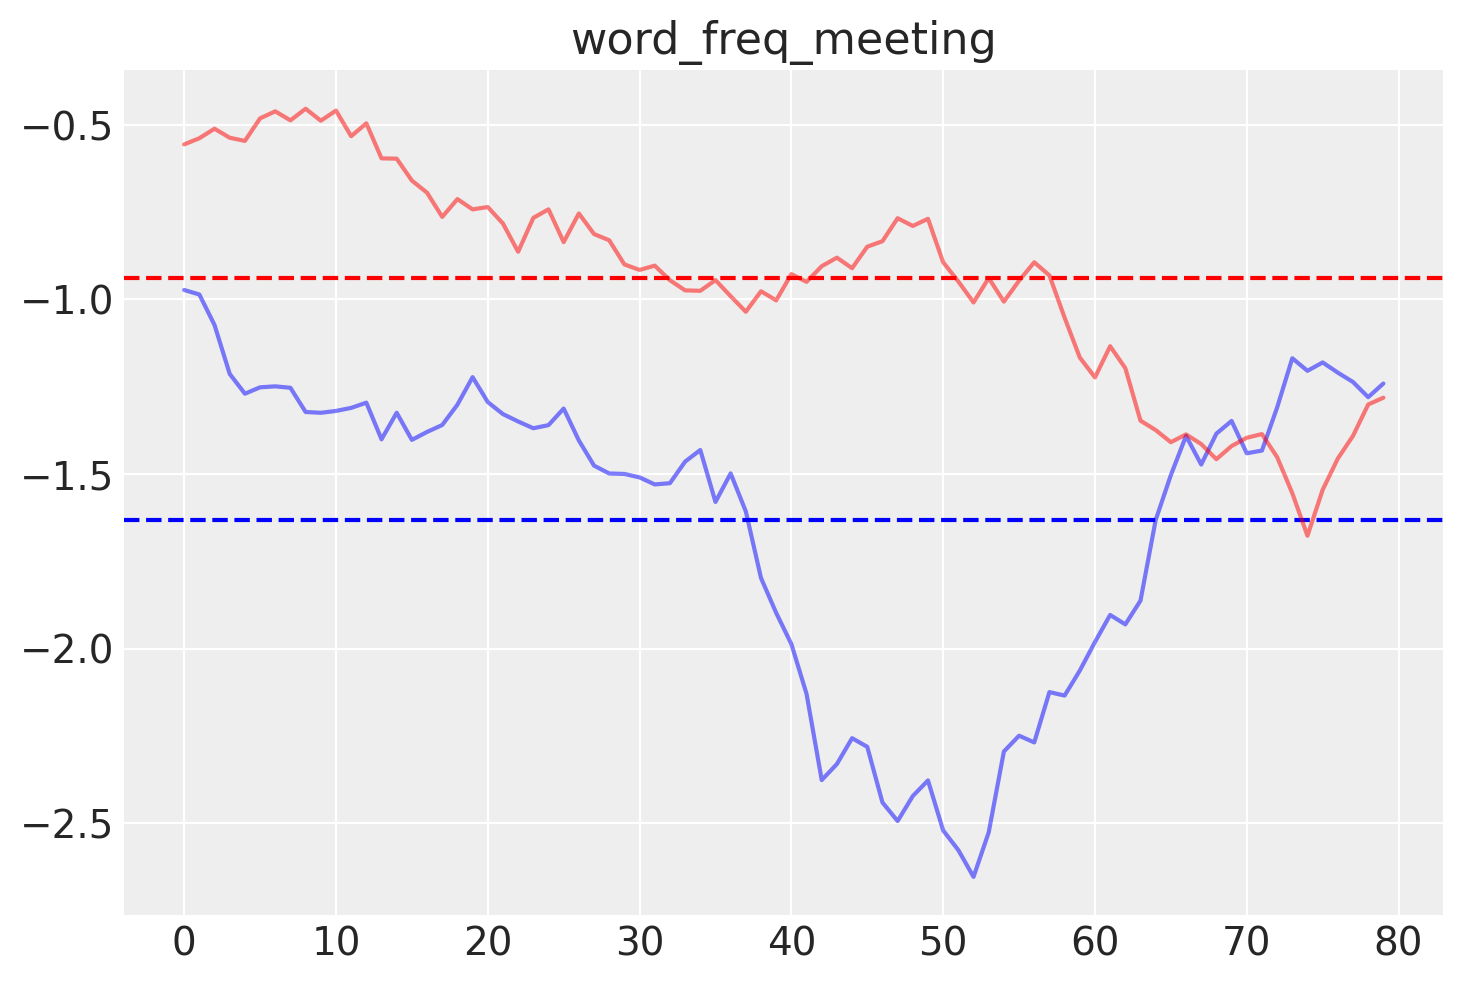

In [83]:
for coeff in coeffs:
    for i in range(n_chains):
        trajectory = betas1[i,n_start:,coeff]
        plt.plot(trajectory, color = colors[i], alpha = 0.5)
        plt.axhline(y=np.mean(trajectory), linestyle="--", color = colors[i])
    plt.title(ticks[coeff])
    plt.show()